<a href="https://colab.research.google.com/github/meliskarayigit/Deepl/blob/main/End_to_End_Structred_Data_Modeling_with_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to End Structred Data Modeling with ANN

In [ ]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.10.0 Tensorflow Current Version: 2.19.0


Data Preparation

Imports and Settings

In [ ]:
import numpy as np
import pandas as pd
from joblib import dump,load #save for the model
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

data_path='/content/diabetes.csv'

Normalizing Input and Save the Scaler

In [ ]:
def preprocess_data(filepath):
  data=pd.read_csv(filepath)
  scaler=StandardScaler()
  X= scaler.fit_transform(data.drop('Outcome', axis=1)) #remoce Outcome column
  y=data['Outcome'].values
  dump(scaler,'scaler.joblib') # save scaler object
  return X,y

In [ ]:
X,y= preprocess_data(data_path)

Train Validation and Tensorflow Dataset

In [ ]:
X_train,X_val,y_train,y_val= train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
def prepare_datasets(X_train,X_val, y_train,  y_val, batch_size=None):
  if batch_size is None:
    batch_size=len(X_train)

  train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train))
  train_dataset= train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

  val_dataset= tf.data.Dataset.from_tensor_slices((X_val,y_val))
  val_dataset= val_dataset.batch(batch_size)

  return train_dataset,val_dataset


In [ ]:
train_ds, val_ds= prepare_datasets(X_train, X_val, y_train, y_val)

In [ ]:
for features,label in train_ds.take(5):
  print("features:", features.numpy(), "label:", label.numpy())



features: [[ 0.04601433  0.47275805  0.04624525 ... -0.10059342  2.14465784
  -0.95646168]
 [ 0.04601433 -0.68523633  0.35643175 ... -1.11594738 -0.75163597
  -1.04154944]
 [ 0.04601433 -0.12188771 -0.36733675 ... -0.29097229 -0.27747734
  -0.27575966]
 ...
 [ 0.93691372 -0.84172205 -0.26394125 ...  0.165937    0.80372515
   0.66020563]
 [ 0.63994726  1.03610667  0.25303625 ... -0.34173998  1.10875714
   0.49003012]
 [-0.54791859 -1.06080207 -3.57259724 ... -0.39250768  0.9094293
  -0.70119842]] label: [1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0
 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1

# Model

Build the Model

In [ ]:
model=Sequential([
    keras.layers.Input(shape=(train_ds.element_spec[0].shape[1],)), #it gives shape from tensorflow dataset
    Dense(50,activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [ ]:
optimizer= SGD(learning_rate=0.01, momentum=0.0) #StochasticGradientDescent
#sgd works as full batch gradient descent since we have full batch size
#momentum =0  orks as full batch gradient descent
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

Callbacks

In [ ]:
early_stopping=EarlyStopping(
    monitor='val_loss' ,#stop according to the validation loss
    patience=20, #if there is no improvement wait 20 iteration
    verbose=1, #report yes
    restore_best_weights=True #save weights
    )

model_checkpoint= ModelCheckpoint(
    'best_model.keras', #save best model physically
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)
#save model checkpoint to reduce train time when we restart the model

Model Training

In [ ]:
history= model.fit(train_ds,
                   epochs=1000,
                   validation_data= val_ds,
                   verbose=2,
                   callbacks=[early_stopping,model_checkpoint]
                   )

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.73162, saving model to best_model.keras
1/1 - 1s - 1s/step - AUC: 0.4433 - accuracy: 0.4381 - loss: 0.9913 - val_AUC: 0.3415 - val_accuracy: 0.6039 - val_loss: 0.7316
Epoch 2/1000

Epoch 2: val_loss improved from 0.73162 to 0.72668, saving model to best_model.keras
1/1 - 0s - 44ms/step - AUC: 0.4432 - accuracy: 0.4235 - loss: 1.0776 - val_AUC: 0.3511 - val_accuracy: 0.6039 - val_loss: 0.7267
Epoch 3/1000

Epoch 3: val_loss improved from 0.72668 to 0.72251, saving model to best_model.keras
1/1 - 0s - 39ms/step - AUC: 0.4529 - accuracy: 0.4397 - loss: 1.0249 - val_AUC: 0.3644 - val_accuracy: 0.6039 - val_loss: 0.7225
Epoch 4/1000

Epoch 4: val_loss improved from 0.72251 to 0.71822, saving model to best_model.keras
1/1 - 0s - 46ms/step - AUC: 0.5212 - accuracy: 0.5130 - loss: 0.9664 - val_AUC: 0.3761 - val_accuracy: 0.6039 - val_loss: 0.7182
Epoch 5/1000

Epoch 5: val_loss improved from 0.71822 to 0.71442, saving model to best_model.k

In [ ]:
model.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 8),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 50,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
  

In [ ]:

for layer in model.layers:
  config = layer.get_config()
  print(f"Layer type: {type(layer).__name__}")
  print("Initializer for weights:", config.get('kernel_initializer'))

Layer type: Dense
Initializer for weights: {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}
Layer type: BatchNormalization
Initializer for weights: None
Layer type: Dropout
Initializer for weights: None
Layer type: Dense
Initializer for weights: {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}


# Evaluating Model Results

Best Epoch and Training History

In [ ]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

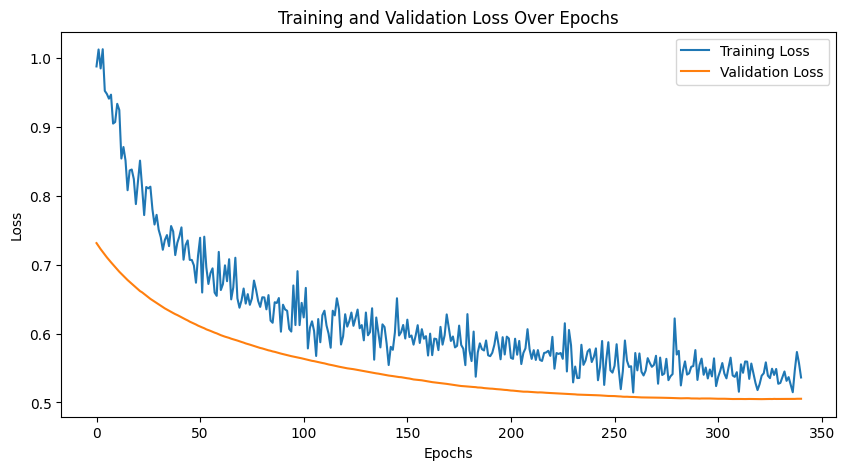

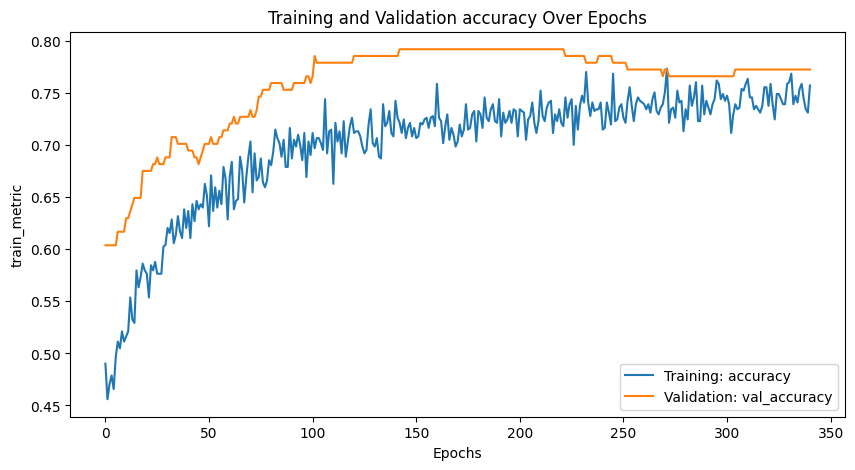

In [ ]:
plot_training_history(history)

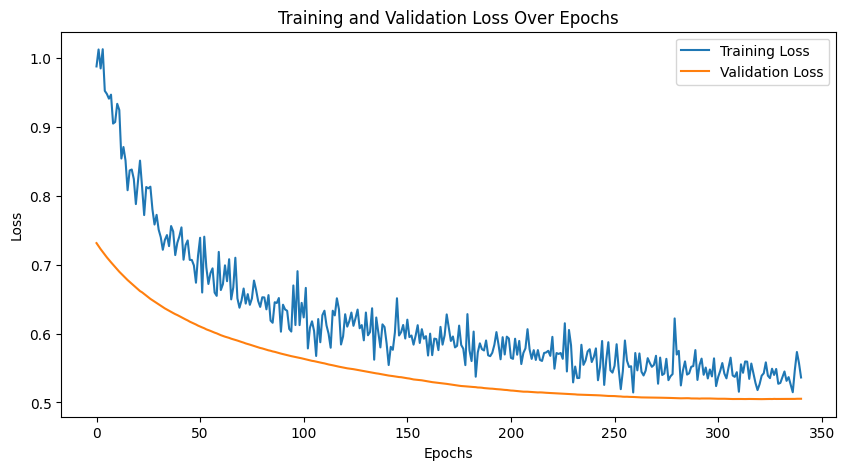

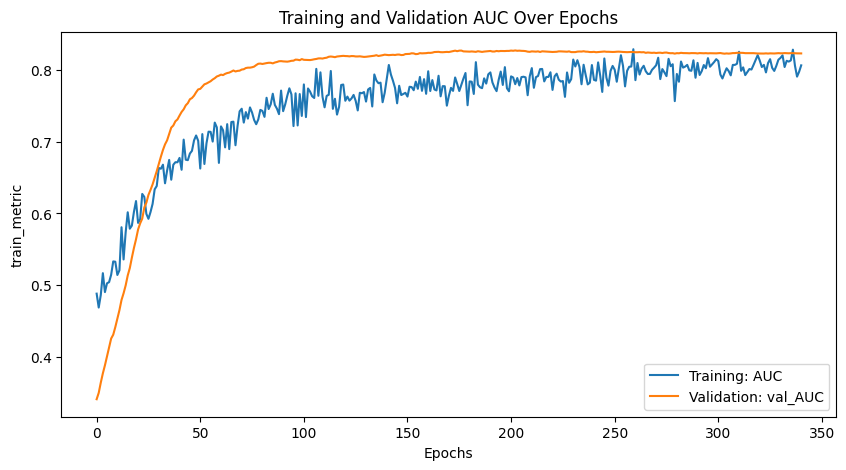

In [ ]:
plot_training_history(history,train_metric="AUC", val_metric="val_AUC")

In [ ]:
def get_best_epoch_details(history):
  val_losses= history.history['val_loss']
  min_val_loss_index= val_losses.index(min(val_losses))
  best_epoch=min_val_loss_index +1

  epoch_details={}
  for key in history.history.keys():
    epoch_details[key]=history.history[key][min_val_loss_index]

  epoch_details['best_epoch']=best_epoch
  return epoch_details

In [ ]:
get_best_epoch_details= get_best_epoch_details(history)
print(f"Best epoch details: {get_best_epoch_details}")

Best epoch details: {'AUC': 0.7928125858306885, 'accuracy': 0.732899010181427, 'loss': 0.5452032685279846, 'val_AUC': 0.8249770402908325, 'val_accuracy': 0.7662337422370911, 'val_loss': 0.503723680973053, 'best_epoch': 351}


Loading the Best Model

In [ ]:
best_model= load_model('best_model.keras')

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 703 (2.75 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 100 (400.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
best_model.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 8),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 50,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
  

Weights and Biases

In [ ]:
def print_model_weights_biases(model,show_values=False):
  for layer in model.layers:
    weights_biases= layer.get_weights()
    if weights_biases:
      print(f"Layer: {layer.name}")
      for i,wb in enumerate(weights_biases):
        if i==0:
          type_wb="Weights"
        else:
          type_wb= "Biases"
        print(f"  {type_wb} (Count: {wb.size}):")
        print(f"    Min: {np.min(wb):.4f}")
        print(f"    Max: {np.max(wb):.4f}")
        print(f"    Mean: {np.mean(wb):.4f}")
        print(f"    Std Dev: {np.std(wb):.4f}")
        if show_values:
           print(f"    Values: {wb}")
        else:
            print(f"Layer {layer.name} has no weights or biases.")




In [ ]:
print_model_weights_biases(best_model,show_values=False)

Layer: dense
  Weights (Count: 400):
    Min: -0.3413
    Max: 0.3657
    Mean: -0.0021
    Std Dev: 0.1868
Layer dense has no weights or biases.
  Biases (Count: 50):
    Min: -0.0428
    Max: 0.0437
    Mean: -0.0005
    Std Dev: 0.0193
Layer dense has no weights or biases.
Layer: batch_normalization
  Weights (Count: 50):
    Min: 0.9584
    Max: 1.0030
    Mean: 0.9888
    Std Dev: 0.0122
Layer batch_normalization has no weights or biases.
  Biases (Count: 50):
    Min: -0.0894
    Max: 0.0755
    Mean: 0.0057
    Std Dev: 0.0498
Layer batch_normalization has no weights or biases.
  Biases (Count: 50):
    Min: 0.0864
    Max: 0.2907
    Mean: 0.1956
    Std Dev: 0.0434
Layer batch_normalization has no weights or biases.
  Biases (Count: 50):
    Min: 0.0535
    Max: 0.2421
    Mean: 0.1255
    Std Dev: 0.0420
Layer batch_normalization has no weights or biases.
Layer: dense_1
  Weights (Count: 50):
    Min: -0.2337
    Max: 0.3464
    Mean: -0.0104
    Std Dev: 0.1532
Layer dense_1

# Prediction

Loading Model and Scaler Object

In [ ]:
scaler=load('/content/scaler.joblib')
diabetes_model= load_model('/content/best_model.keras')

New Observation

In [ ]:
new_data= np.array([[6,148,72,35,0,33.6,0.627,50]])
scaled_data= scaler.transform(new_data)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Prediction

In [ ]:
prediction= diabetes_model.predict(scaled_data)
prediction_outcome= (prediction>0.5).astype(int)

print(f"Class probability: {prediction} Class Prediction: {prediction_outcome}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class probability: [[0.7367839]] Class Prediction: [[1]]


# Prediction with Tensorflow Datasets

In [ ]:
data_path= '/content/diabetes.csv'
diabetes_data= pd.read_csv(data_path)

In [ ]:
#since i dont have new data, select 100 sample randomly
def random_samples(scaler,data,num_samples=100):
  X=data.drop('Outcome',axis=1)
  X_scaled= scaler.fit_transform(X)
  new_dataset= tf.data.Dataset.from_tensor_slices((X_scaled)).batch(len(X))
  return new_dataset

In [ ]:
random_samples=random_samples(scaler,diabetes_data)

In [ ]:
diabetes_model.predict(random_samples)[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


array([[0.73678386],
       [0.07607441],
       [0.8443779 ],
       [0.0558081 ],
       [0.8299149 ],
       [0.18344706],
       [0.095372  ],
       [0.55805063],
       [0.89191324],
       [0.06636151]], dtype=float32)

In [ ]:
prediction= diabetes_model.predict(random_samples)[:10]
prediction_outcome= (prediction>0.5).astype(int)

print(f"Class probability: {prediction} Class Prediction: {prediction_outcome}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class probability: [[0.73678386]
 [0.07607441]
 [0.8443779 ]
 [0.0558081 ]
 [0.8299149 ]
 [0.18344706]
 [0.095372  ]
 [0.55805063]
 [0.89191324]
 [0.06636151]] Class Prediction: [[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]]
